# Predicting Water Quality: Safe or Not Safe for Consumption  #

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif

Possible future ideas: Model to see *how* safe water is to drink, which would be more of a regression model than a classification model


## Introduction: ##

### Why is water safety an important topic? ###

Water is an essential nutrie to all who call Earth their home, andnd access to safe drinking water is a component of effective policy for health protection, preventing the spread of infectious disease According to the World Health Organization (2023), in 2022 alone, "115 million people collect[ed] untreated surface water from lakes, ponds, rivers and streams." As such, these waters are far more prone to contaminants that may strike people with intense illnesses, like cholera, diarrhoea, dysentery, hepatitis A, typhoid and polio. Given that these unsafe waters put hundreds of millions of people across the globe at risk, water safety is a serious health and development issue at a national, regional, and local level (World Health Orginization, 2023). 

### Background Information & Our Question ###

Given how large of a concern water safety is, we ask the question: **can we construct a model that predicts and classifies whether a sample of water is safe to consume or not, given a set of contaminant levels?** In our exploration of this question, the predictors we will be using are the most common contaminants water tends to carry, which includes arsenic, bacteria, lead, nitrates, nitrites, and viruses (United States Environmental Protection Agency, 2015). Our model will use a k-nearest neighbors classification algorithm, which involves collecting a certain amount of observations that harvest data on the predictors and the classifications themselves, and then using this data to "train our model," such that we can classify a new observation that only contains predictors, but not classification. We do this by finding the k-nearest data points, such that the distance between the new obeservation and an existing observation in our dataset is the lowest. 

### Dataset Being Used ##

The dataset we are using was found on Kaggle (https://www.kaggle.com/datasets/mssmartypants/water-quality), and it provides information on different contaminants in water and their maximum concentration allowed to be present for water to remain safe to use. It contains 20 predictor variables (contaminant levels within water), and one binary response variable (whether or not the water is safe to drink). However, for our uses, 20 predictor variables is too high of a number, therefore, as mentioned earlier, we will limit our model to use the 6 most common contaminants in water. As such, our usage of the dataset will pull from data surrounding arsenic, bacteria, lead, nitrates, nitrites, and viruses, all given in level per litre. 

In [68]:
library(tidyverse)
library(tidymodels)

raw_data <- read_csv("data/waterQuality1.csv") |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0'))|>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe)

slice_sample(raw_data, n = 5)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 7999 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): aluminium, ammonia, arsenic, barium, cadmium, chloramine, chromium...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.00,0.760,0.110,9.67,0.34,not safe
0.05,0.00,0.006,0.041,18.76,0.59,not safe
0.07,0.00,0.005,0.097,7.35,0.06,not safe
0.02,0.52,0.520,0.185,17.51,1.63,not safe
0.05,0.00,0.610,0.164,17.36,0.15,not safe


^This is a small glimpse of our data set. There are 20 variables and one class variable which will be used as our predicting class. Our prediction will be based on the amount of different materials in water samples which will be used to predict if water is safe or not.

In [70]:
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

In [71]:
water_train_table <- water_train |>
    group_by(is_safe)|>
    summarize(count = n())|>
    mutate(percentage = count / nrow(water_train) * 100)
water_train_table

is_safe,count,percentage
<fct>,<int>,<dbl>
not safe,5313,88.56476079
safe,684,11.40190032
NA,2,0.03333889


^This table represents the amount and proportion of water samples that are safe and are not in the training data set. 

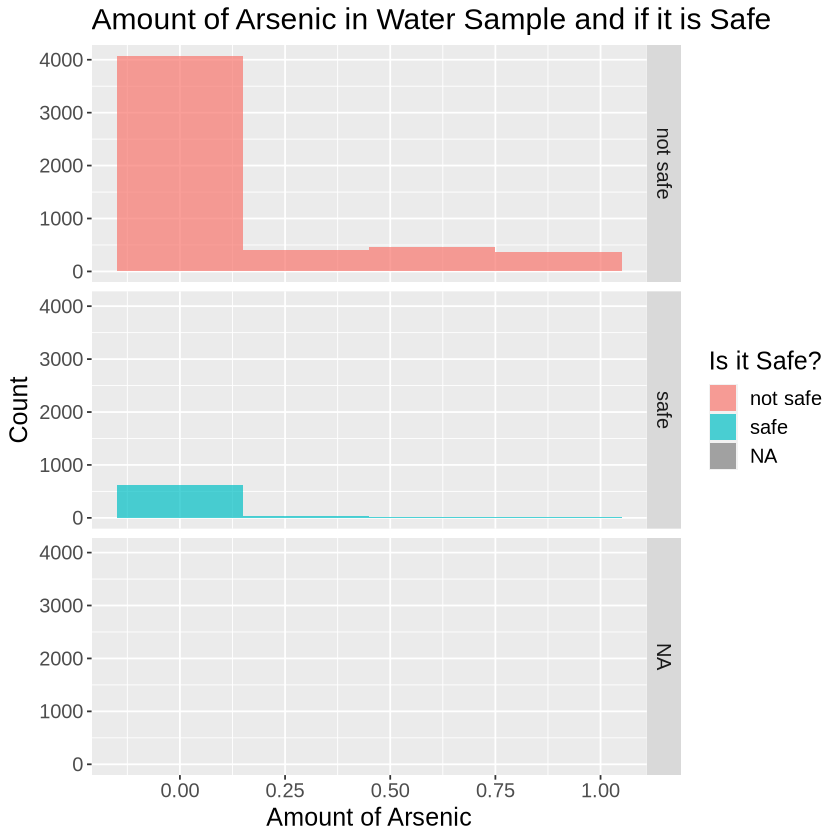

In [73]:
water_train_plot <- water_train |>
    ggplot(aes(x = arsenic, fill = is_safe)) +
    geom_histogram(alpha = 0.7, position = 'identity', binwidth = 0.3) +
    facet_grid(rows = vars(is_safe)) +
    labs(x = 'Amount of Arsenic', y = 'Count', fill = 'Is it Safe?') +
    theme(text = element_text(size = 15)) +
    ggtitle('Amount of Arsenic in Water Sample and if it is Safe')
water_train_plot

^This is one of many plots that can describe our situation. In this case, the frequency of levels of aluminum in water is plotted, and whether the sample is safe or not is represented as seperate plots and colors. This was plotted using the training data set.

## References: ##

https://www.who.int/news-room/fact-sheets/detail/drinking-water

https://www.epa.gov/sites/default/files/2015-10/documents/ace3_drinking_water.pdf